In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder, StandardScaler
from xgboost import XGBClassifier

In [2]:
df = pd.read_csv('weatherAUS.csv')
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [3]:
df.dtypes

Date              object
Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
Temp9am          float64
Temp3pm          float64
RainToday         object
RainTomorrow      object
dtype: object

In [4]:
df = df.dropna(subset='RainTomorrow', axis=0)

In [5]:
df['Date'] = pd.to_datetime(df['Date']).astype('int64')

In [12]:
X = df.drop('RainTomorrow', axis=1)
y = pd.DataFrame(df['RainTomorrow'])

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=0)

sample_row = X.loc[0].to_dict()

In [7]:
num_cols = list(X_train.select_dtypes('number'))
cat_cols = list(X_train.select_dtypes('object'))


le = LabelEncoder()

y_train_encoded = le.fit_transform(y_train)
y_valid_encoded = le.transform(y_valid)

num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder())
])

preprocessing = ColumnTransformer(transformers=[
    ('num_pipeline', num_pipeline, num_cols),
    ('cat_pipeline', cat_pipeline, cat_cols),
    ], remainder='passthrough',
    n_jobs=-1
)

model = XGBClassifier()

pipeline = Pipeline(steps=[
    ('col_trans', preprocessing),
    ('model', model)
])

pipeline.fit(X_train, y_train_encoded)
preds = pipeline.predict(X_valid)

print(f'accuracy: {accuracy_score(y_valid_encoded, preds)}')


/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


accuracy: 0.8610577148483286


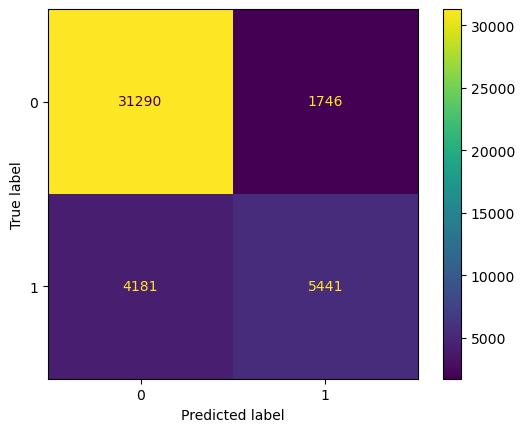

In [8]:
cm = confusion_matrix(y_valid_encoded, preds)
ConfusionMatrixDisplay(cm).plot()

In [16]:
import pickle

with open('pipeline.pkl', 'wb') as file:
    pickle.dump(pipeline, file)

with open('label_encoder.pkl', 'wb') as file:
    pickle.dump(le, file)

In [17]:
from pydantic import BaseModel, ValidationError

class Weather(BaseModel):
    Date: object
    Location: object
    MinTemp: float
    MaxTemp: float
    Rainfall: float
    Evaporation: float
    Sunshine: float
    WindGustDir: object
    WindGustSpeed: float
    WindDir9am: object
    WindDir3pm: object
    WindSpeed9am: float
    WindSpeed3pm: float
    Humidity9am: float
    Humidity3pm: float
    Pressure9am: float
    Pressure3pm: float
    Cloud9am: float
    Cloud3pm: float
    Temp9am: float
    Temp3pm: float
    RainToday: object

with open('pipeline.pkl', 'rb') as file:
    loaded_pipeline = pickle.load(file)

with open('label_encoder.pkl', 'rb') as file:
    loaded_le = pickle.load(file)

print(sample_row)
weather = Weather(**sample_row)
inputs = pd.DataFrame([weather.model_dump()])
pred = loaded_pipeline.predict(inputs)[0]
pred
    


{'Date': 1228089600000000000, 'Location': 'Albury', 'MinTemp': 13.4, 'MaxTemp': 22.9, 'Rainfall': 0.6, 'Evaporation': nan, 'Sunshine': nan, 'WindGustDir': 'W', 'WindGustSpeed': 44.0, 'WindDir9am': 'W', 'WindDir3pm': 'WNW', 'WindSpeed9am': 20.0, 'WindSpeed3pm': 24.0, 'Humidity9am': 71.0, 'Humidity3pm': 22.0, 'Pressure9am': 1007.7, 'Pressure3pm': 1007.1, 'Cloud9am': 8.0, 'Cloud3pm': nan, 'Temp9am': 16.9, 'Temp3pm': 21.8, 'RainToday': 'No'}


0

In [18]:
from flask import Flask, jsonify, request

app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict():
    try:
        weather = Weather(**request.json)
        inputs = pd.DataFrame([weather.model_dump()])
        pred = loaded_pipeline.predict(inputs)
        actual_pred = loaded_le.inverse_transform(pred)[0]
        response = {
            'prediction': actual_pred
        }

        return jsonify(response), 200
    except ValidationError as e:
        return jsonify(e.errors()), 400

if __name__ == '__main__': 
    app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [11/Oct/2024 07:59:58] "POST /predict HTTP/1.1" 200 -
